#### Importing the libraries

In [137]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

In [58]:
from math import pi
from qiskit_ibm_provider import IBMProvider
from qiskit import execute, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import PhaseGate
from qiskit.tools import job_monitor

#### Important and much needed utilities for building our high-level quantum circuits

In [41]:
def bin_to_dec(string:str)->int:
    """A utility function to convert binary numbers to decimal"""
    string = string[::-1]
    dec = 0
    for i,s in zip(range(len(string)), string):
        dec += (2**i)*int(s)
    return dec

In [3]:
def prepare_state(bit_string : str):
    """Applies PauliX gates to qubits wherever there is a computational 1 state in the input"""
    bit_string = bit_string[::-1]
    n = len(bit_string)
    qc = QuantumCircuit(n)
    for i, s in zip(range(n), bit_string):
        if s == '1':
            qc.x(i)
    return qc

def equalize_lengths(str1, str2):
    """Pads zeroes to the most significant bit of the number with lesser number of bits"""
    p,q = len(str1), len(str2)
    
    if p>q:
        str2 = '0'*(p-q) + str2
    elif q>p:
        str1 = '0'*(q-p) + str1
        
    return str1, str2

# QFT from scratch
def qft_rotations(circuit, n:int):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n:int):
    """Does the swap operation of the qubits"""
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n:int, do_swaps:bool=True):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    if do_swaps:
        swap_registers(circuit, n)
    return circuit

def inverse_qft(circuit, n:int, do_swaps:bool=True):
    """Does the inverse QFT on the first n qubits in circuit"""
    if do_swaps:
        # First we create a QFT circuit of the correct size:
        qft_circ = qft(QuantumCircuit(n), n)
        # Then we take the inverse of this circuit
        invqft_circ = qft_circ.inverse()
    else:
        qft_circ = qft(QuantumCircuit(n), n, do_swaps=False)
        invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit

## **QFT Adder**
#### The QFT Adder is a quantum circuit that stores the sum of two input numbers in the output register

In [43]:
def QFT_ADD(num1:str, num2:str):
    """Using the QFT to build a circuit that stores the sum of two numbers in the output register"""
    
    p,q = len(num1), len(num2)
    
    if p!=q:
        num1, num2 = equalize_lengths(num1, num2)
    n = len(num1)    
    
    qft_circ_1 = QuantumCircuit(2*n+1,n+1)

    qft_circ_1.append(prepare_state(num1), list(range(n)))
    qft_circ_1.append(prepare_state(num2), list(range(n,2*n)))

    qft_circ_1.barrier()

    qft_circ_1.append(qft(QuantumCircuit(n+1), n+1, do_swaps=False), list(range(n,2*n+1)))

    qft_circ_1.barrier()

    for k in range(n):
        theta_1 = 2*pi / 2**(k+2)
        qft_circ_1.cp(theta_1, control_qubit=n-k-1, target_qubit=2*n)

    for i in range(n):
        for j in range(n-i):
            theta = 2*pi / 2**(j+1)
            qft_circ_1.cp(theta, control_qubit=n-i-j-1, target_qubit=2*n-i-1)

    qft_circ_1.barrier()

    qft_circ_1.append(inverse_qft(QuantumCircuit(n+1), n+1, do_swaps=False), list(range(n,2*n+1)))

    qft_circ_1.barrier()

    qft_circ_1.measure(list(range(n,2*n+1)), list(range(n+1)))
    
    return qft_circ_1

An example demonstration of the above Adder

Enter the first number:  3
Enter the second number:  32


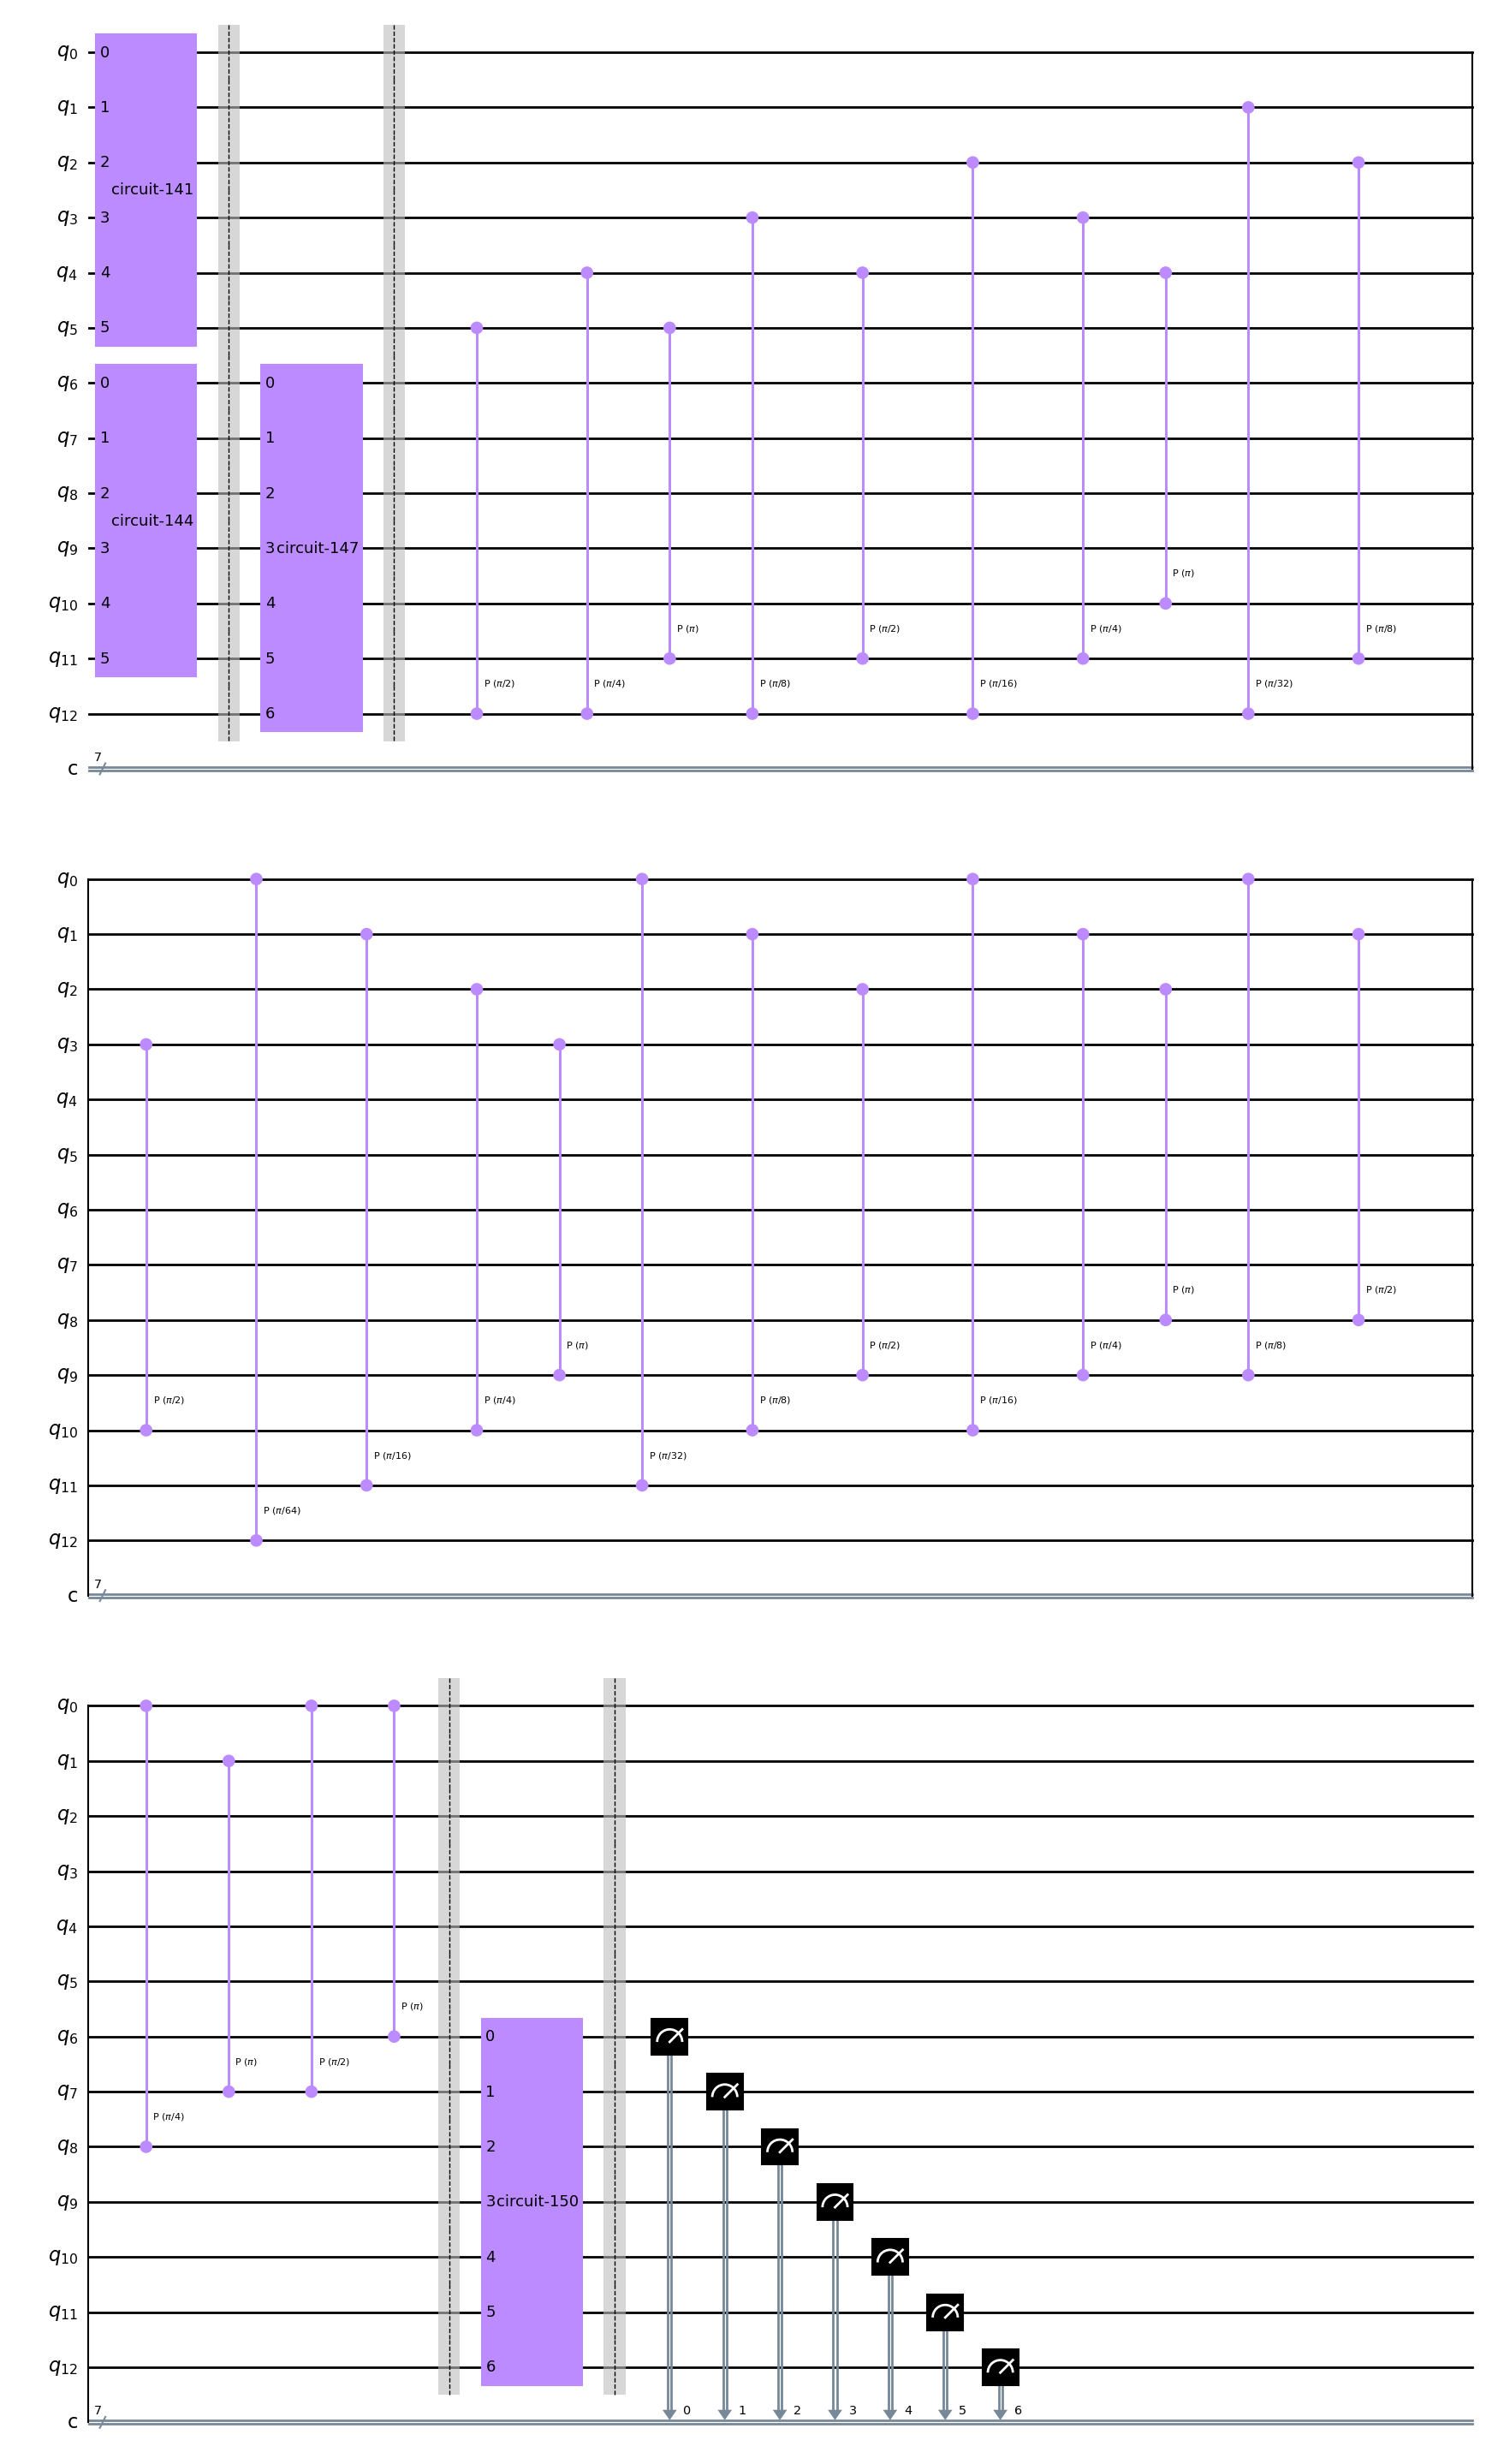

In [38]:
input1 = bin(int(input("Enter the first number: ")))[2:]
input2 = bin(int(input("Enter the second number: ")))[2:]

test1 = QFT_ADD(input1, input2)
test1.draw()

In [40]:
no_times_to_run_simulation = 2400
print(f"Result counts:", execute(test1, backend=AerSimulator(), shots=no_times_to_run_simulation).result().get_counts())
print(f"The sum of {bin_to_dec(input1)} and {bin_to_dec(input2)} = {bin_to_dec(list(execute(test1, backend=AerSimulator(), shots=no_times_to_run_simulation).result().get_counts().keys())[0])}")

Result counts: {'0100011': 2400}
The sum of 3 and 32 = 35


## **QFT Multiplier**
#### The QFT Multiplier is a quantum circuit that is, in a way, an extension of the QFT Adder in that it performs those controlled phase rotation unitary operations with every bit of one of the input registers as the control targeting the other quantum registers to store the product value in the final output register (with the help of QFT).
#### **NOTE**: The circuit that is implemented here gives the exact value of the result, but it can also be made to be modular multiplication with a specific modulus by varying the number of ancillary qubits.

Just like for the QFT Adder, the procedure is: 
1. State preparation
2. QFT (Phase-Encoding)
3. Controlled Phase Rotation Gates
4. Inverse QFT (Decoding the result)
5. Measurement (in the computational basis)

In [42]:
def qft_mult_rotations(n):
    """A function for the controlled phase rotations in the multiplication circuit"""
    
    q_input1 = QuantumRegister(n, name='input1')
    q_input2 = QuantumRegister(n, name='input2')
    q_output = QuantumRegister(2*n, name='output')
    
    qc = QuantumCircuit(q_input1, q_input2, q_output)

    for j in range(1,n+1):
        for i in range(1, n+1):
            for k in range(1,2*n+1):
                phase = 2*pi / 2**(i+j+k-2*n)
                gate = PhaseGate(phase).control(2)
                qc.append(gate, [q_input1[n-j], q_input2[n-i], q_output[k-1]])
                
    return qc

In [44]:
def QFT_MULTIPLY(num1:str, num2:str):
    """
    Using the QFT to build a circuit that stores the product of two numbers in the output register.
    
    Args:
    --------
    num1 (str) : first input in the binary format
    num2 (str) : second input in the binary format
    
    Returns:
    ---------
    A quantum circuit object (an instance of the QuantumCircuit class).
    """
    
    if len(num1) != len(num2):
        num1, num2 = equalize_lengths(num1, num2)
    n = len(num1)

    q1 = QuantumRegister(n, name='input1')
    q2 = QuantumRegister(n, name='input2')
    q3 = QuantumRegister(2*n, name='output')
    c = ClassicalRegister(2*n, name='meas')
    qc = QuantumCircuit(q1,q2,q3,c)

    qc.append(prepare_state(num1), list(range(n)))
    qc.append(prepare_state(num2), list(range(n,2*n)))

    qc.barrier()
    qc.append(qft(QuantumCircuit(2*n), 2*n, do_swaps=False), list(range(2*n, 4*n)))
    qc.barrier()

    qc.append(qft_mult_rotations(n), list(range(4*n)))

    qc.barrier()
    qc.append(inverse_qft(QuantumCircuit(2*n), 2*n, do_swaps=False), list(range(2*n, 4*n)))
    qc.barrier()

    qc.measure(list(range(2*n, 4*n)), list(range(2*n)))
    
    return qc

An example demonstration of the multiplier circuit

Enter the first number:  23
Enter the second number:  3


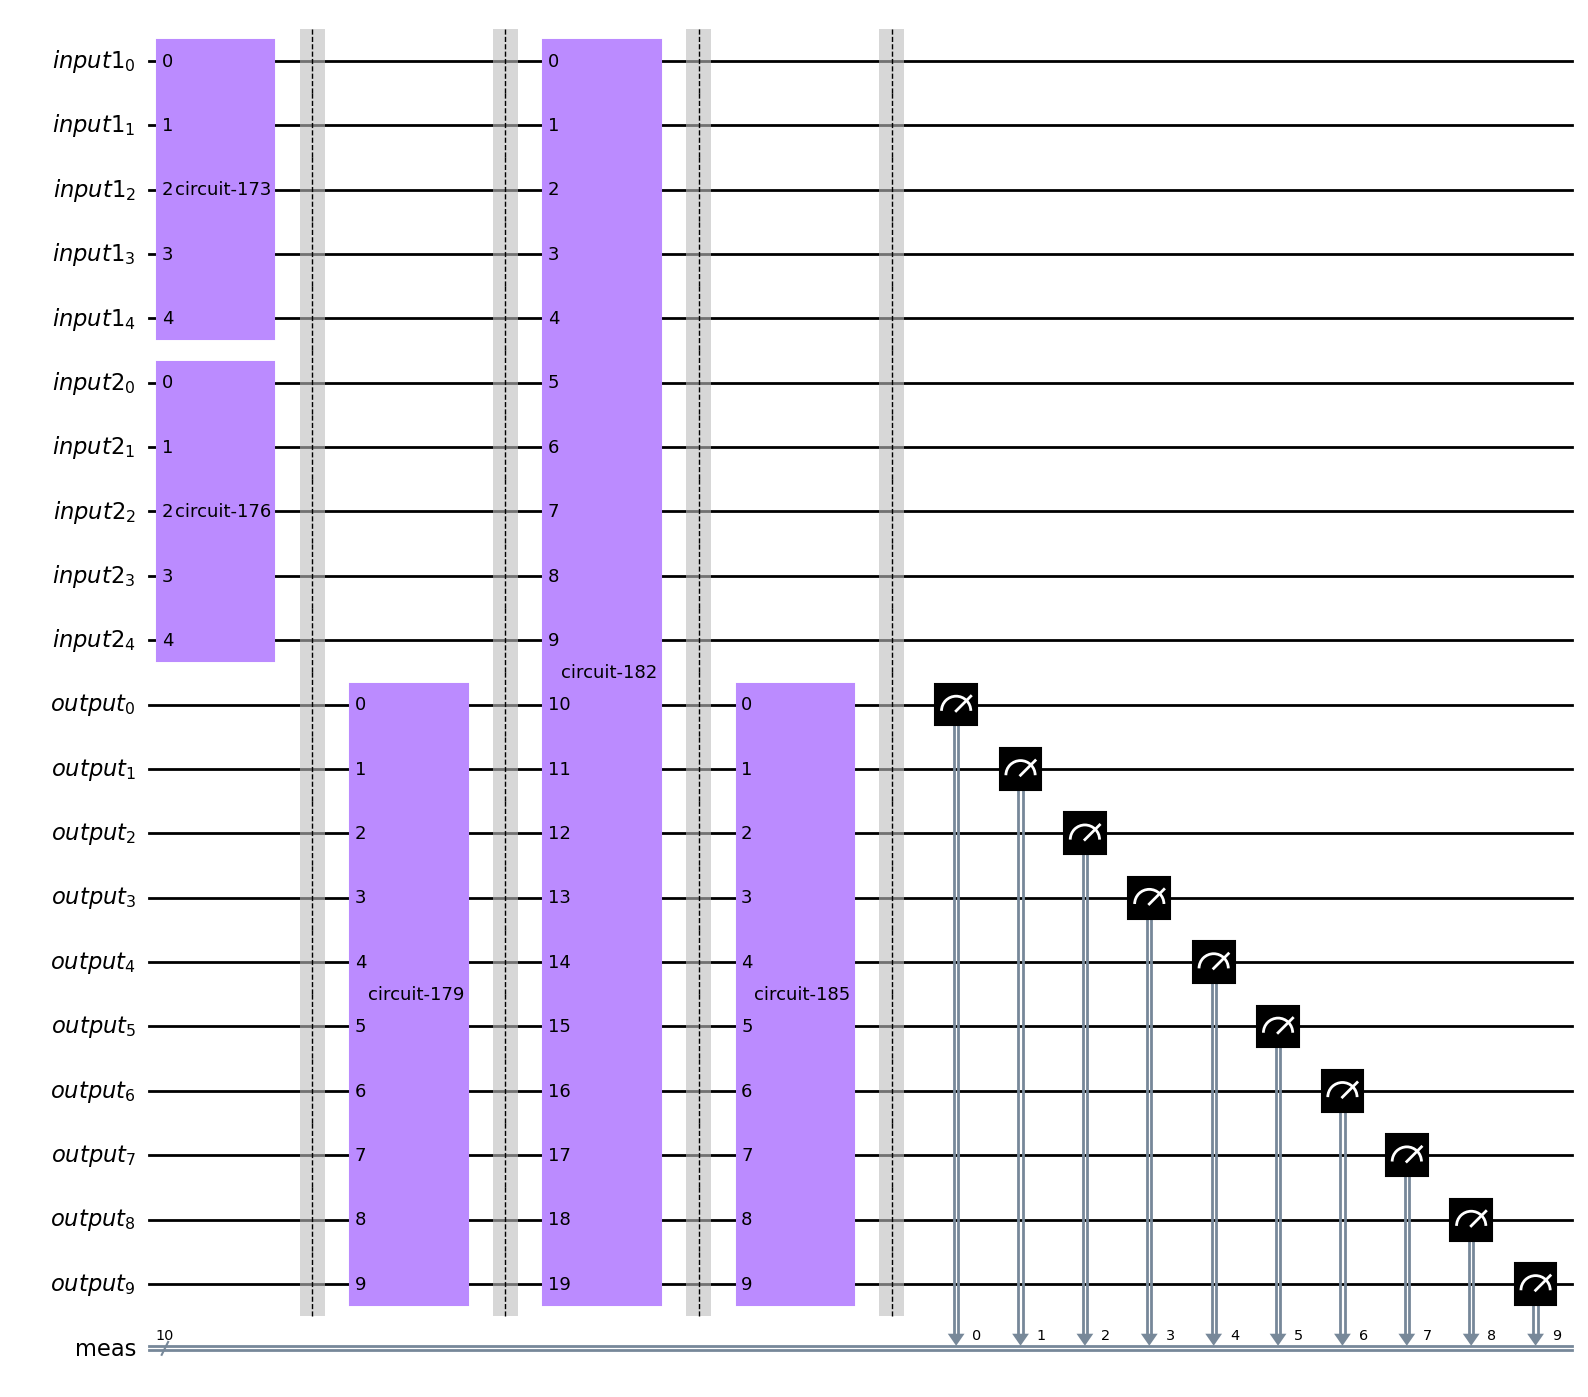

In [49]:
input_1 = bin(int(input("Enter the first number: ")))[2:]
input_2 = bin(int(input("Enter the second number: ")))[2:]
test2 = QFT_MULTIPLY(input_1, input_2)
test2.draw()

**Running on a simulator**

In [50]:
no_times_to_run_simulation
simulator = AerSimulator()
sim = execute(test2, backend=simulator, shots=no_times_to_run_simulation)
result_sim = sim.result()
counts_sim = result_sim.get_counts()
print("Result counts:", counts_sim)
print(f"The product of {bin_to_dec(input_1)} and {bin_to_dec(input_2)} = {bin_to_dec(list(counts_sim.keys())[0])}")

Result counts: {'0001000101': 2400}
The product of 23 and 3 = 69


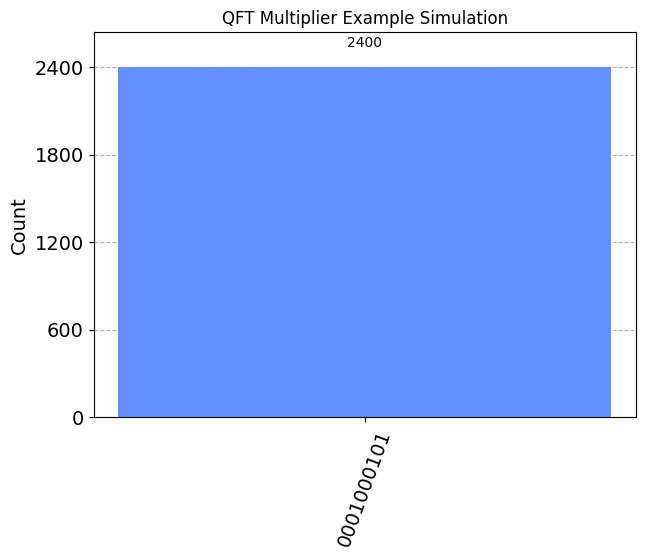

In [51]:
plot_histogram(counts_sim, title="QFT Multiplier Example Simulation")

Since all the real quantum backends that are available as of now have no more than 7 qubits, we shall consider the following example for our QFT Muliplier circuit being run on both an _Aer Simulator_ backend and a real _IBM Quantum_ backend. Comparing both the idea simulation and the real-time quantum computation results, we will see that the circuit is indeed performing the way it is intended to. 

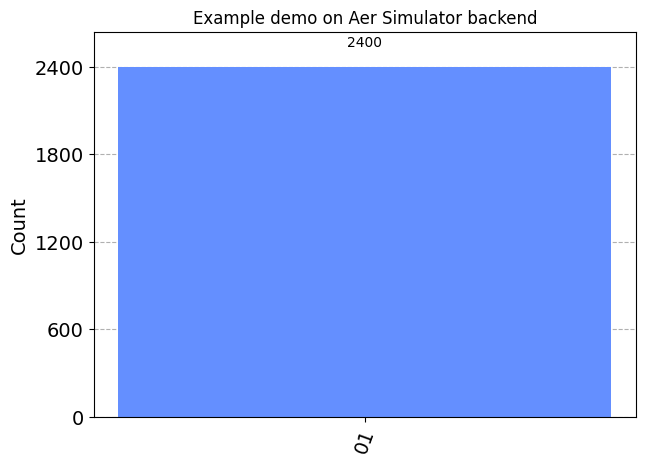

In [136]:
# Example of multiplying '01' (1) and '01' (1)
plot_histogram(execute(QFT_MULTIPLY('1', '1'), backend=AerSimulator(), shots=2400).result().get_counts(), title="Example demo on Aer Simulator backend")

**Running on a real quantum backend**

In [52]:
my_backends = IBMProvider.backends(IBMProvider())
my_backends

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_jakarta')>]

In [103]:
for backend in my_backends:
    print("Name:", backend.name)
    status = backend.status()
    print("Pending Jobs:", status.pending_jobs)
    # print("Number of qubits:", backend.num_qubits)
    # print(backend.coupling_map)
    print("Is operational:", status.operational)
    print("---------------------------------------------------------------------------")

Name: ibmq_qasm_simulator
Pending Jobs: 0
Is operational: True
---------------------------------------------------------------------------
Name: ibmq_quito
Pending Jobs: 0
Is operational: True
---------------------------------------------------------------------------
Name: ibmq_belem
Pending Jobs: 0
Is operational: True
---------------------------------------------------------------------------
Name: simulator_mps
Pending Jobs: 0
Is operational: True
---------------------------------------------------------------------------
Name: simulator_statevector
Pending Jobs: 0
Is operational: True
---------------------------------------------------------------------------
Name: simulator_stabilizer
Pending Jobs: 0
Is operational: True
---------------------------------------------------------------------------
Name: ibmq_manila
Pending Jobs: 0
Is operational: True
---------------------------------------------------------------------------
Name: ibmq_lima
Pending Jobs: 0
Is operational: True
---

In [86]:
my_backends

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_jakarta')>]

In [132]:
from qiskit import IBMQ
my_account = IBMQ.load_account()
# my_account??

ibmqfactory.load_account:WARNING:2023-05-08 10:03:27,248: Credentials are already in use. The existing account in the session will be replaced.


In [114]:
my_ibmq_backends = my_account.backends()
my_ibmq_backends

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_lagos') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairo

In [116]:
my_account.services()

{'backend': <qiskit.providers.ibmq.ibmqbackendservice.IBMQBackendService at 0x7f784dd17b50>,
 'runtime': <qiskit.providers.ibmq.runtime.ibm_runtime_service.IBMRuntimeService at 0x7f784ddaee00>}

In [123]:
my_ibmq_backends_names = list(my_account._discover_remote_backends())
my_ibmq_backends_names

['ibmq_qasm_simulator',
 'ibmq_lima',
 'ibmq_belem',
 'ibmq_quito',
 'simulator_statevector',
 'simulator_mps',
 'simulator_extended_stabilizer',
 'simulator_stabilizer',
 'ibmq_jakarta',
 'ibmq_manila',
 'ibm_lagos',
 'ibm_nairobi',
 'ibm_perth']

In [128]:
for backend in my_ibmq_backends:
    print("Name:", backend.name())
    status = backend.status()
    print("Pending Jobs:", status.pending_jobs)
    print("Is operational:", status.operational)
    print("---------------------------------------------------------------------------")

Name: ibmq_qasm_simulator
Pending Jobs: 0
Is operational: True
---------------------------------------------------------------------------
Name: ibmq_lima
Pending Jobs: 21
Is operational: True
---------------------------------------------------------------------------
Name: ibmq_belem
Pending Jobs: 22
Is operational: True
---------------------------------------------------------------------------
Name: ibmq_quito
Pending Jobs: 43
Is operational: True
---------------------------------------------------------------------------
Name: simulator_statevector
Pending Jobs: 0
Is operational: True
---------------------------------------------------------------------------
Name: simulator_mps
Pending Jobs: 0
Is operational: True
---------------------------------------------------------------------------
Name: simulator_extended_stabilizer
Pending Jobs: 0
Is operational: True
---------------------------------------------------------------------------
Name: simulator_stabilizer
Pending Jobs: 0
Is 

In [129]:
b = my_ibmq_backends[1]
job = b.run(transpile(QFT_MULTIPLY('1', '1'), backend=b), shots=8000)  # Unlike in simulation, we are running our QFT_MULTIPLY circuit for 8000 times for more accurate results
print(job_monitor(job))
result = job.result()
counts = result.get_counts()

Job Status: job has successfully run
None


In [130]:
print("Result counts:", counts)

Result counts: {'00': 1615, '01': 3363, '10': 1736, '11': 1286}


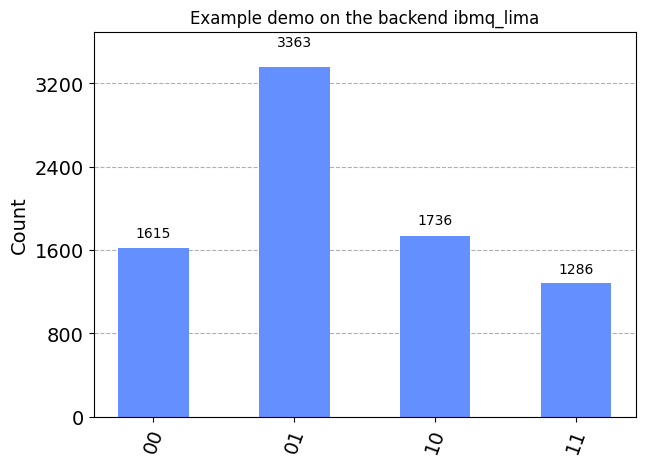

In [131]:
plot_histogram(counts, title=f"Example demo on the backend {b.name()}")

As can be seen, the probability distribution is heavily weighed on the correct answer 1 ('01'), which is indeed what one times one is. However, because of some inevitable noise (could be gate noise or the state noise/qubit-decoherence or could be some other form of error in the measurements), the quantum computer (here, 'IBMQ-Lima') occaionally output other answers too that are incorrect. <br>
It is highly important to correct for these errors in our measurements or gates to make our quantum computations as robust to these errors as possible, which is what makes quantum computers reliable.